In [1]:
%load_ext autoreload
%autoreload 2

# ExpectationValue

In [2]:
import numpy as np

In [3]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import PauliSumOp

observable = PauliSumOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)
print("observable\n", observable)

ansatz = RealAmplitudes(num_qubits=2, reps=2)
print("ansatz\n", ansatz)

observable
 -1.052373245772859 * II
+ 0.39793742484318045 * IZ
- 0.39793742484318045 * ZI
- 0.01128010425623538 * ZZ
+ 0.18093119978423156 * XX
ansatz
      ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘


In [4]:
from qiskit.quantum_info import Statevector

expval = Statevector(ansatz.bind_parameters([0, 1, 1, 2, 3, 5])).expectation_value(
    observable.primitive
)
print(expval.real)

-1.284366511861733


/Users/aa406165/Git/qiskit-core/qiskit/quantum_info/states/statevector.py:444: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  for z, x, coeff in zip(oper.table.Z, oper.table.X, oper.coeffs)


## ExpectationValue class

In [5]:
from qiskit.evaluators import PauliExpectationValue

### PauliExpectationValue

Evaluate the expectation value by sampling. This supports both AerSimulator and IBMQ backends.

In [6]:
from qiskit.providers.aer import AerSimulator

backend = AerSimulator()

In [7]:
expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([0, 1, 1, 2, 3, 5], shos=1000)

ExpectationValueResult(value=-1.263619750229793, variance=0.303678732575533, confidence_interval=(-1.29253282456233, -1.234706675897256))

In [8]:
# pre-binding

circuit = ansatz.bind_parameters([0, 1, 1, 2, 3, 5])
expval = PauliExpectationValue(circuit, observable, backend=backend)
expval.evaluate()

ExpectationValueResult(value=-1.2751031157644306, variance=0.30593696641366713, confidence_interval=(-1.3041070672235413, -1.2460991643053199))

In [9]:
# multi prameters

expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]], shots=3000)

ExpectationValueArrayResult(values=array([-1.27769394, -1.32240884]), variances=array([0.3030364 , 0.24212723]), confidence_intervals=array([[-1.29456278, -1.2608251 ],
       [-1.3371496 , -1.30766809]]))

In [10]:
# can pass ndarray
expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate(np.array([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]]), shots=8192)

ExpectationValueArrayResult(values=array([-1.28988318, -1.32140738]), variances=array([0.30035609, 0.24389652]), confidence_intervals=array([[-1.30004626, -1.27972009],
       [-1.33036994, -1.31244482]]))

### Exact simulation by SaveExpectationValueVariance

In [11]:
from qiskit.evaluators import ExactExpectationValue

In [12]:
expval = ExactExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([0, 1, 1, 2, 3, 5])

ExpectationValueResult(value=-1.2843665118617325, variance=0.26528532962023577, confidence_interval=None)

In [13]:
expval = ExactExpectationValue(ansatz, observable, backend=backend)
expval.evaluate(np.array([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]]))

ExpectationValueArrayResult(values=array([-1.28436651, -1.31875263]), variances=array([0.26528533, 0.42691205]), confidence_intervals=array([None, None], dtype=object))

### Transpiled Circuits

In [14]:
from qiskit.test.mock import FakeBogota

backend = AerSimulator.from_backend(FakeBogota())

expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.set_transpile_options(initial_layout=[3, 2])
print(expval.evaluate([0, 1, 1, 2, 3, 5]))
for circ in expval.transpiled_circuits:
    print(circ)

ExpectationValueResult(value=-1.2399118010914065, variance=0.32139624486300367, confidence_interval=(-1.269630658827474, -1.2101929433553391))
global phase: π
                                                                »
ancilla_0 -> 0 ─────────────────────────────────────────────────»
                                                                »
ancilla_1 -> 1 ─────────────────────────────────────────────────»
               ┌────┐┌──────────────┐┌────┐┌────────┐┌───┐┌────┐»
      q_1 -> 2 ┤ √X ├┤ Rz(θ[1] + π) ├┤ √X ├┤ Rz(3π) ├┤ X ├┤ √X ├»
               ├────┤├──────────────┤├────┤├────────┤└─┬─┘├────┤»
      q_0 -> 3 ┤ √X ├┤ Rz(θ[0] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ √X ├»
               └────┘└──────────────┘└────┘└────────┘     └────┘»
ancilla_2 -> 4 ─────────────────────────────────────────────────»
                                                                »
          c: 2/═════════════════════════════════════════════════»
                                                 

### Transpile options and Run options

In [15]:
expval = PauliExpectationValue(ansatz, observable, backend=backend)
# setter
expval.set_transpile_options(optimization_level=2)
expval.set_run_options(shots=100_000)
expval.evaluate([0, 1, 1, 2, 3, 5])

ExpectationValueResult(value=-1.258376866290244, variance=0.31346857626923974, confidence_interval=(-1.2613477903234689, -1.255405942257019))

In [16]:
# Method chain
expval.set_run_options(shots=8192).evaluate([0, 1, 1, 2, 3, 5])

ExpectationValueResult(value=-1.2511288466508719, variance=0.3133545552948115, confidence_interval=(-1.2615092317745646, -1.240748461527179))

In [17]:
# evaluate's option
expval.evaluate([0, 1, 1, 2, 3, 5], shots=300)

ExpectationValueResult(value=-1.2738504033690927, variance=0.31611486850504716, confidence_interval=(-1.3283165449888366, -1.2193842617493489))

### Composite Evaluator

In [18]:
from qiskit.evaluators import JointEvaluator

In [19]:
len(expval.transpiled_circuits)

5

In [20]:
joint_evaluator = JointEvaluator([expval, expval, expval])  # can be different evaluator

In [21]:
len(joint_evaluator.transpiled_circuits)  # 3 × 3

15

In [22]:
joint_evaluator.evaluate([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8], [1, 2, 3, 5, 8, 13]])

CompositeResult(items=[ExpectationValueResult(value=-1.2528964012602428, variance=0.11814465820420435, confidence_interval=(-1.2636377067105846, -1.242155095809901)), ExpectationValueResult(value=-1.2528964012602428, variance=0.11814465820420435, confidence_interval=(-1.2636377067105846, -1.242155095809901)), ExpectationValueResult(value=-1.2528964012602428, variance=0.11814465820420435, confidence_interval=(-1.2636377067105846, -1.242155095809901))])

### Readout error mitigation

In [23]:
from qiskit.evaluators.backends import ReadoutErrorMitigation

backend = AerSimulator.from_backend(FakeBogota())
mit_tensored = ReadoutErrorMitigation(
    backend, mitigation="tensored", refresh=600, shots=2000, mit_pattern=[[0], [1]]
)
mit_mthree = ReadoutErrorMitigation(
    backend, mitigation="mthree", refresh=600, shots=2000, qubits=[0, 1]
)
expval_raw = PauliExpectationValue(ansatz, observable, backend=backend)
expval_tensored = PauliExpectationValue(ansatz, observable, backend=mit_tensored)
expval_mthree = PauliExpectationValue(ansatz, observable, backend=mit_mthree)
shots = 4000
print(
    f"w/o mitigation shots={shots}, result={expval_raw.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}"
)
print(
    f"w/ tensored mitigation shots={shots}, result={expval_tensored.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}"
)
print(
    f"w/ M3 mitigation shots={shots}, result={expval_mthree.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}"
)

w/o mitigation shots=4000, result=ExpectationValueResult(value=-1.2567305619532785, variance=0.31317540565690255, confidence_interval=(-1.271580175778457, -1.2418809481281))
w/ tensored mitigation shots=4000, result=ExpectationValueResult(value=-1.278259083872444, variance=0.2983091313985497, confidence_interval=(-1.2927626885789347, -1.263755479165953))
w/ M3 mitigation shots=4000, result=ExpectationValueResult(value=-1.2789456420976917, variance=0.302783122281774, confidence_interval=(-1.2935537564498927, -1.2643375277454907))


### Gradient of expectation value

In [24]:
from qiskit.evaluators.expectation_value.expectation_value_gradient import (
    FiniteDiffGradient,
    ParameterShiftGradient,
)

In [25]:
parameters = [0, 1, 1, 2, 3, 5]

exact_expval = ExactExpectationValue(ansatz, observable, backend=AerSimulator())
exact_findiff = FiniteDiffGradient(exact_expval, 1e-8)
print(f"fin diff of exact {exact_findiff.evaluate(parameters).values}")

exact_expval = ExactExpectationValue(ansatz, observable, backend=AerSimulator())
exact_findiff = ParameterShiftGradient(exact_expval)
print(f"param shift of exact {exact_findiff.evaluate([0, 1, 1, 2, 3, 5]).values}")

shots = 2000
findiff = FiniteDiffGradient(expval_raw, 1e-1)
paramshift = ParameterShiftGradient(expval_raw)
print(f"fin diff w/o mit {findiff.evaluate(parameters, shots=shots).values}")
print(
    f"param shift w/o mit {paramshift.evaluate(parameters, shots=shots).values}"
)

findiff = FiniteDiffGradient(expval_mthree, 1e-1)
paramshift = ParameterShiftGradient(expval_mthree)
print(f"fin diff w/  mit {findiff.evaluate([0, 1, 1, 2, 3, 5], shots=shots).values}")
print(
    f"param shift w/  mit {paramshift.evaluate(parameters, shots=shots).values}"
)

fin diff of exact [ 0.28213347  0.42656751  0.20442583  0.42656749 -0.17291453  0.0589814 ]
param shift of exact [ 0.28213349  0.42656754  0.20442588  0.42656754 -0.17291452  0.05898141]
fin diff w/o mit [0.32659224 0.69278855 0.25397074 0.75346883 0.03862138 0.23463255]
param shift w/o mit [ 0.24004867  0.37858695  0.18421508  0.37300477 -0.13684331  0.07460206]
fin diff w/  mit [ 0.43973398  0.76978544  0.30424064  0.64577515 -0.26589061  0.17901179]
param shift w/  mit [ 0.25545302  0.41783316  0.20019311  0.3974433  -0.16552306  0.06749017]


### VQE by Scipy optimizer

In [28]:
from scipy.optimize import minimize

shots = 1000
expval = PauliExpectationValue(ansatz, observable, backend=AerSimulator(), append=True)
paramshift = ParameterShiftGradient(expval)
# this may take a long time...
result = minimize(
    lambda x: expval.evaluate(x, shots=shots).value,
    np.zeros(6),
    jac=lambda x: paramshift.evaluate(x, shots=shots).values,
)
print(result)

      fun: -1.881383447399938
 hess_inv: array([[ 1.74054526, -0.14962923, -0.10736193, -0.18102418, -0.28687537,
         1.14259697],
       [-0.14962923,  0.72981147, -0.77497584, -0.26850474,  0.11715862,
        -0.02541937],
       [-0.10736193, -0.77497584,  2.32054439,  0.41741422,  0.72945468,
        -0.51775336],
       [-0.18102418, -0.26850474,  0.41741422,  0.93635391, -0.06061401,
         0.25127455],
       [-0.28687537,  0.11715862,  0.72945468, -0.06061401,  0.58249384,
        -0.62957824],
       [ 1.14259697, -0.02541937, -0.51775336,  0.25127455, -0.62957824,
         1.96824137]])
      jac: array([-0.02265453,  0.0098548 ,  0.02013367,  0.0089057 , -0.02982063,
       -0.01668424])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 49
      nit: 11
     njev: 32
   status: 2
  success: False
        x: array([ 0.59130994, -1.00354165, -1.84094146, -1.09497792,  0.77445326,
        0.9096065 ])


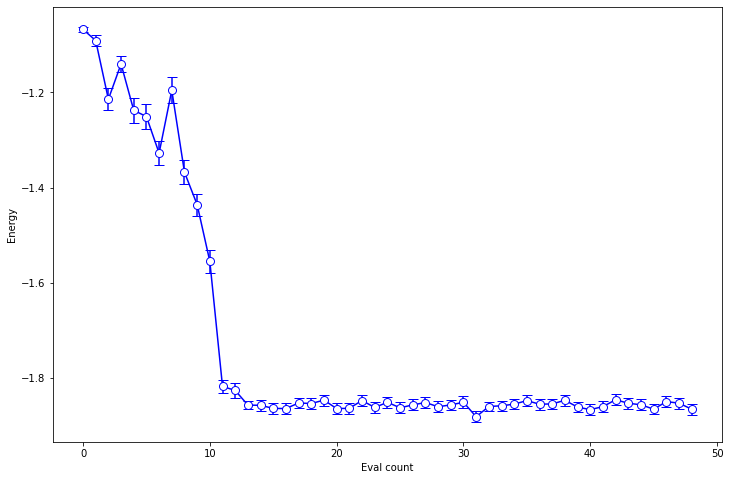

In [29]:
import matplotlib.pyplot as plt
from qiskit.evaluators.results import ExpectationValueResult

plt.figure(figsize=(12, 8))
y = [h.value for h in expval.history if isinstance(h, ExpectationValueResult)]
x = list(range(len(y)))
yerr = np.array(
    [
        tuple(abs(c - h.value) for c in h.confidence_interval)
        for h in expval.history
        if isinstance(h, ExpectationValueResult)
    ]
).transpose()
plt.plot(y, color="blue")
plt.errorbar(
    x,
    y,
    yerr=yerr,
    capsize=5,
    fmt="o",
    markersize=8,
    ecolor="blue",
    markeredgecolor="blue",
    color="w",
)
plt.xlabel("Eval count")
plt.ylabel("Energy")
plt.show()